# colab settings:

In [0]:
!pip install PyDrive

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# download to Colab from Google Drive:
# https://drive.google.com/open?id=YOUR_FILE_ID
download = drive.CreateFile({'id': '10AWC5jfxqdDXode3_1vkDKZpWVeAROV4'}) # 'id': 'YOUR_FILE_ID'
download.GetContentFile('dataset.tar')

In [0]:
# upload to Google Drive from Colab:
upload = drive.CreateFile({'title': 'DRIVE.txt'})
upload.SetContentFile('FILE_ON_COLAB.txt')
upload.Upload()

In [1]:
!ls

adc.json  dataset.tar  INRIAPerson  sample_data


In [0]:
!tar -xvf dataset.tar

# Train CNN classifier from keras on INRIA dataset

Tutorial: https://towardsdatascience.com/image-detection-from-scratch-in-keras-f314872006c9

Code on git: https://github.com/risenW/medium_tutorial_notebooks/blob/master/dogs-vs-cats-keras-implementation.ipynb


In [2]:
from skimage.io import imread
from skimage import data, color
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import numpy as np
import os

import gc # garbage collector

from keras import layers
from keras import models
from keras import optimizers
from keras import initializers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

Using TensorFlow backend.


In [0]:
# define parameters of HOG feature extraction
# change them if necessary to orientations = 8, pixels per cell = (16,16), cells per block to (1,1) for weaker HOG
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
threshold = .3
# 9 * 4(16x16 / 8x8) = 36 
# 36 * 105 (7 * 15 - pos of 16x16) 3780

# define size for train and test data
PERSON_WIDTH = 64
PERSON_HEIGHT = 128
leftop_train = [16, 16]
rightbottom_train = [16 + PERSON_WIDTH, 16 + PERSON_HEIGHT]
leftop_test = [3, 3]
rightbottom_test = [3 + PERSON_WIDTH, 3 + PERSON_HEIGHT]

In [0]:
# COLAB
# define path to images:

#train_pos_img_dir = '/content/drive/My Drive/Colab Notebooks/Project31/INRIAPerson/train_64x128_H96/pos/'
#train_neg_img_dir = '/content/drive/My Drive/Colab Notebooks/Project31/INRIAPerson/train_64x128_H96/neg/'
#test_pos_img_dir = '/content/drive/My Drive/Colab Notebooks/Project31/INRIAPerson/test_64x128_H96/pos/'
#test_neg_img_dir = '/content/drive/My Drive/Colab Notebooks/Project31/INRIAPerson/test_64x128_H96/neg/'



In [0]:
# JUPYTER or COLAB (dataset.tar)
# define path to images:

train_pos_img_dir = 'INRIAPerson/train_64x128_H96/pos/'
train_neg_img_dir = 'INRIAPerson/train_64x128_H96/neg/'
test_pos_img_dir = 'INRIAPerson/test_64x128_H96/pos/'
test_neg_img_dir = 'INRIAPerson/test_64x128_H96/neg/'

In [5]:
# read the image files:
train_pos_images = os.listdir(train_pos_img_dir)
train_neg_images = os.listdir(train_neg_img_dir)
test_pos_images = os.listdir(test_pos_img_dir)
test_neg_images = os.listdir(test_neg_img_dir)

trainData = []
testData = []
trainLabels = []
testLabels = []

# loading train data
print('loading ' + str(len(train_pos_images)) + ' positive images [Train]')
for train_pos_image in train_pos_images:
    pos_img = data.imread(train_pos_img_dir + train_pos_image, as_gray=False)
    pos_roi = pos_img[leftop_train[1]:rightbottom_train[1], leftop_train[0]:rightbottom_train[0]]
    trainData.append(color.rgba2rgb(pos_roi))  #convert RGBA to RGB
    trainLabels.append(1)

print('loading ' + str(len(train_neg_images)) + ' negative images [Train]')
for train_neg_image in train_neg_images:
    neg_img = data.imread(train_neg_img_dir + train_neg_image, as_gray=False)
    neg_roi = neg_img[leftop_train[1]:rightbottom_train[1], leftop_train[0]:rightbottom_train[0]]
    trainData.append(neg_roi / 255)
    trainLabels.append(0)   

# loading test data    
print('loading ' + str(len(test_pos_images)) + ' positive images [Test]')
for test_pos_image in test_pos_images:
    pos_img = data.imread(test_pos_img_dir + test_pos_image, as_gray=False)
    pos_roi = pos_img[leftop_test[1]:rightbottom_test[1], leftop_test[0]:rightbottom_test[0]]
    testData.append(color.rgba2rgb(pos_roi)) #convert RGBA to RGB
    testLabels.append(1)
    
print('loading ' + str(len(test_neg_images)) + ' negative images [Test]')
for test_neg_image in test_neg_images:
    neg_img = data.imread(test_neg_img_dir + test_neg_image, as_gray=False)
    neg_roi = neg_img[leftop_test[1]:rightbottom_test[1], leftop_test[0]:rightbottom_test[0]]
    testData.append(neg_roi / 255)
    testLabels.append(0)  


loading 2416 positive images [Train]
loading 1218 negative images [Train]
loading 1132 positive images [Test]
loading 453 negative images [Test]


In [0]:
print ('Train data size: {}'.format(np.asarray(trainData).shape))
print ('Test data size: {}'.format(np.asarray(testData).shape))

Train data size: (3634, 128, 64, 3)
Test data size: (1585, 128, 64, 3)


In [0]:
#X_train = np.array(trainData)
#X_val = np.array(testData)
#y_train = np.array(trainLabels)
#y_val = np.array(testLabels)

In [0]:
X = np.concatenate((trainData, testData), axis=0)
y = np.concatenate((trainLabels, testLabels), axis=0)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=True,)

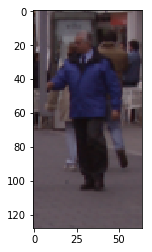

In [0]:
plt.imshow(X_train[-1])

In [8]:
# clear memory
del trainData
del testData
del trainLabels
del testLabels
gc.collect()

10

In [0]:
# Function to create model, required for KerasClassifier
def create_model(
                 learn_rate=0.0001,
                 #optimizer='RMSprop',
                 init_mode='uniform',
                 activation='relu',
                 dropout_rate=0.5,
                 neurons=64,
    
                ):
	# create model  
    model = models.Sequential()
    
    #model.add(layers.InputLayer(input_shape=(128, 64, 3)))

    model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(128, 64, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    #model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    #model.add(layers.MaxPooling2D((2, 2)))
    
    #model.add(layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))

    #model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    #model.add(layers.MaxPooling2D((2, 2)))

    #model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    #model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(neurons, activation=activation, kernel_initializer=init_mode))
    
    model.add(layers.Dropout(dropout_rate))  #Dropout for regularization
    
    model.add(layers.Dense(1, activation='sigmoid', kernel_initializer=init_mode))  #Sigmoid function at the end because we have just two classes
    
    
    # Compile model
    optimizer = optimizers.RMSprop(lr=learn_rate)   
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc'])
    
    return model

In [12]:
model = create_model()
# model description
model.summary()

# after several GridSearches:
# optimizer: RMSprop
# learn_rate: 0.001

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 64, 16)       448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 32, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1048608   
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,049,089
Trainable params: 1,049,089
Non-trainable params: 0
_________________________________________________________________


https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/


In [0]:
# Use scikit-learn to grid search the batch size and epochs
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, 
                        epochs=5, batch_size=16, 
                        verbose=0)
# define the grid search parameters

#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
#init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
#activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
learn_rate = [ 0.0001, 0.1]
#dropout_rate = [0.0, 0.1, 0.5, 0.8]
#neurons = [128, 16, 32, 64]

#batch_size = [4, 8, 16]
#epochs = [5, 10, 100]

param_grid = dict(                 
                 #optimizer=optimizer,
                 #init_mode=init_mode
                 #activation=activation
                 learn_rate=learn_rate,
                 #dropout_rate=dropout_rate
                 #neurons=neurons
    
                 #batch_size=batch_size, epochs=epochs,
                 )

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [0]:
# get the length of the train and validation data
ntrain = len(X_train)
nval = len(X_val)

# batch size should be a facto
#r of 2 ***4,8,16,32,64...***
# 4 for faster training
batch_size = 16

In [0]:
model = create_model()

# RMSprop optimizer with a learning rate of 0.001
# binary_crossentropy loss because its a binary classification
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

In [0]:
# create the augmentation configuration
# this helps prevent overfitting
'''
train_datagen = ImageDataGenerator(rescale=1./255,   # scale the image between 0 and 1
                                   # rotation_range=40,
                                  #  width_shift_range=0.2,
                                   # height_shift_range=0.2,
                                   shear_range=0.2,
                                    zoom_range=0.2,
                                   horizontal_flip=True,
                                  )
                     
val_datagen = ImageDataGenerator(rescale=1./255)  # do not augment validation data, only perform rescale
                                   
'''
val_datagen = ImageDataGenerator()
train_datagen = ImageDataGenerator()


In [0]:
# create the image generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size, 
                                     #shuffle=True
                                    )
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size, 
                                 #shuffle=False
                                )

In [30]:
# the training part
history = model.fit_generator(train_generator,
                              steps_per_epoch=ntrain // batch_size,
                              epochs=10,
                              validation_data=val_generator,
                              validation_steps=nval // batch_size,
                              #shuffle=True
                             )

Epoch 1/10
293/293 [==============================] - 3s 9ms/step - loss: 0.5040 - acc: 0.7750 - val_loss: 0.3957 - val_acc: 0.8202
Epoch 2/10
293/293 [==============================] - 2s 7ms/step - loss: 0.3420 - acc: 0.8529 - val_loss: 0.3601 - val_acc: 0.8360
Epoch 3/10
293/293 [==============================] - 2s 7ms/step - loss: 0.2838 - acc: 0.8804 - val_loss: 0.2568 - val_acc: 0.8874
Epoch 4/10
293/293 [==============================] - 2s 7ms/step - loss: 0.2317 - acc: 0.9130 - val_loss: 0.2193 - val_acc: 0.9051
Epoch 5/10
293/293 [==============================] - 2s 7ms/step - loss: 0.1837 - acc: 0.9337 - val_loss: 0.2000 - val_acc: 0.9121
Epoch 6/10
293/293 [==============================] - 2s 7ms/step - loss: 0.1474 - acc: 0.9512 - val_loss: 0.1362 - val_acc: 0.9447
Epoch 7/10
293/293 [==============================] - 2s 7ms/step - loss: 0.1231 - acc: 0.9586 - val_loss: 0.1150 - val_acc: 0.9545
Epoch 8/10
293/293 [==============================] - 2s 7ms/step - loss: 0.

In [0]:
# save the model
model.save_weights('model_wieghts_batch4_epochs16.h5')
model.save('model_keras_batch4_epochs16.h5')

In [0]:
upload = drive.CreateFile({'title': 'model_keras_batch4_epochs16.h5'})
upload.SetContentFile('model_keras_batch4_epochs16.h5')
upload.Upload()

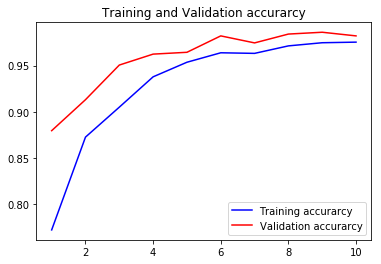

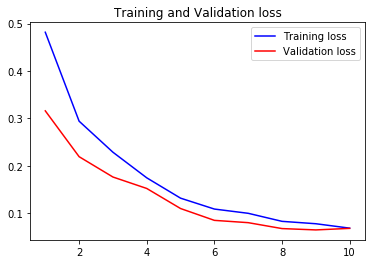

In [0]:
# plot the train and val curve
# get the details form the history object

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
# train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [0]:
test_datagen = ImageDataGenerator() 

test_generator = test_datagen.flow(X_val, y_val, batch_size=1, shuffle=False)
yhat_probs = model.predict_generator(test_generator,steps = nval)

predictions = yhat_probs
yhat_classes = []
for pred in predictions:
    if pred > 0.5:
        yhat_classes.append(1)
    else:
        yhat_classes.append(0)

In [0]:
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = np.asarray(yhat_classes)

In [0]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_val, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_val, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_val, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.980843
Precision: 0.997118
Recall: 0.974648
F1 score: 0.985755


In [0]:
# ROC AUC
auc = roc_auc_score(y_val, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
# tn fp
# fn tp
matrix = confusion_matrix(y_val, yhat_classes)
print(matrix)

ROC AUC: 0.998094
[[166   1]
 [  9 346]]


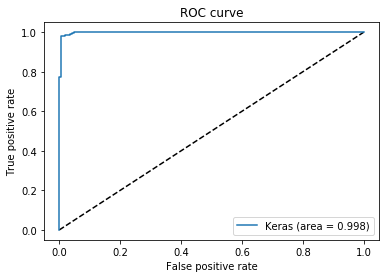

In [0]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, yhat_probs.ravel())

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


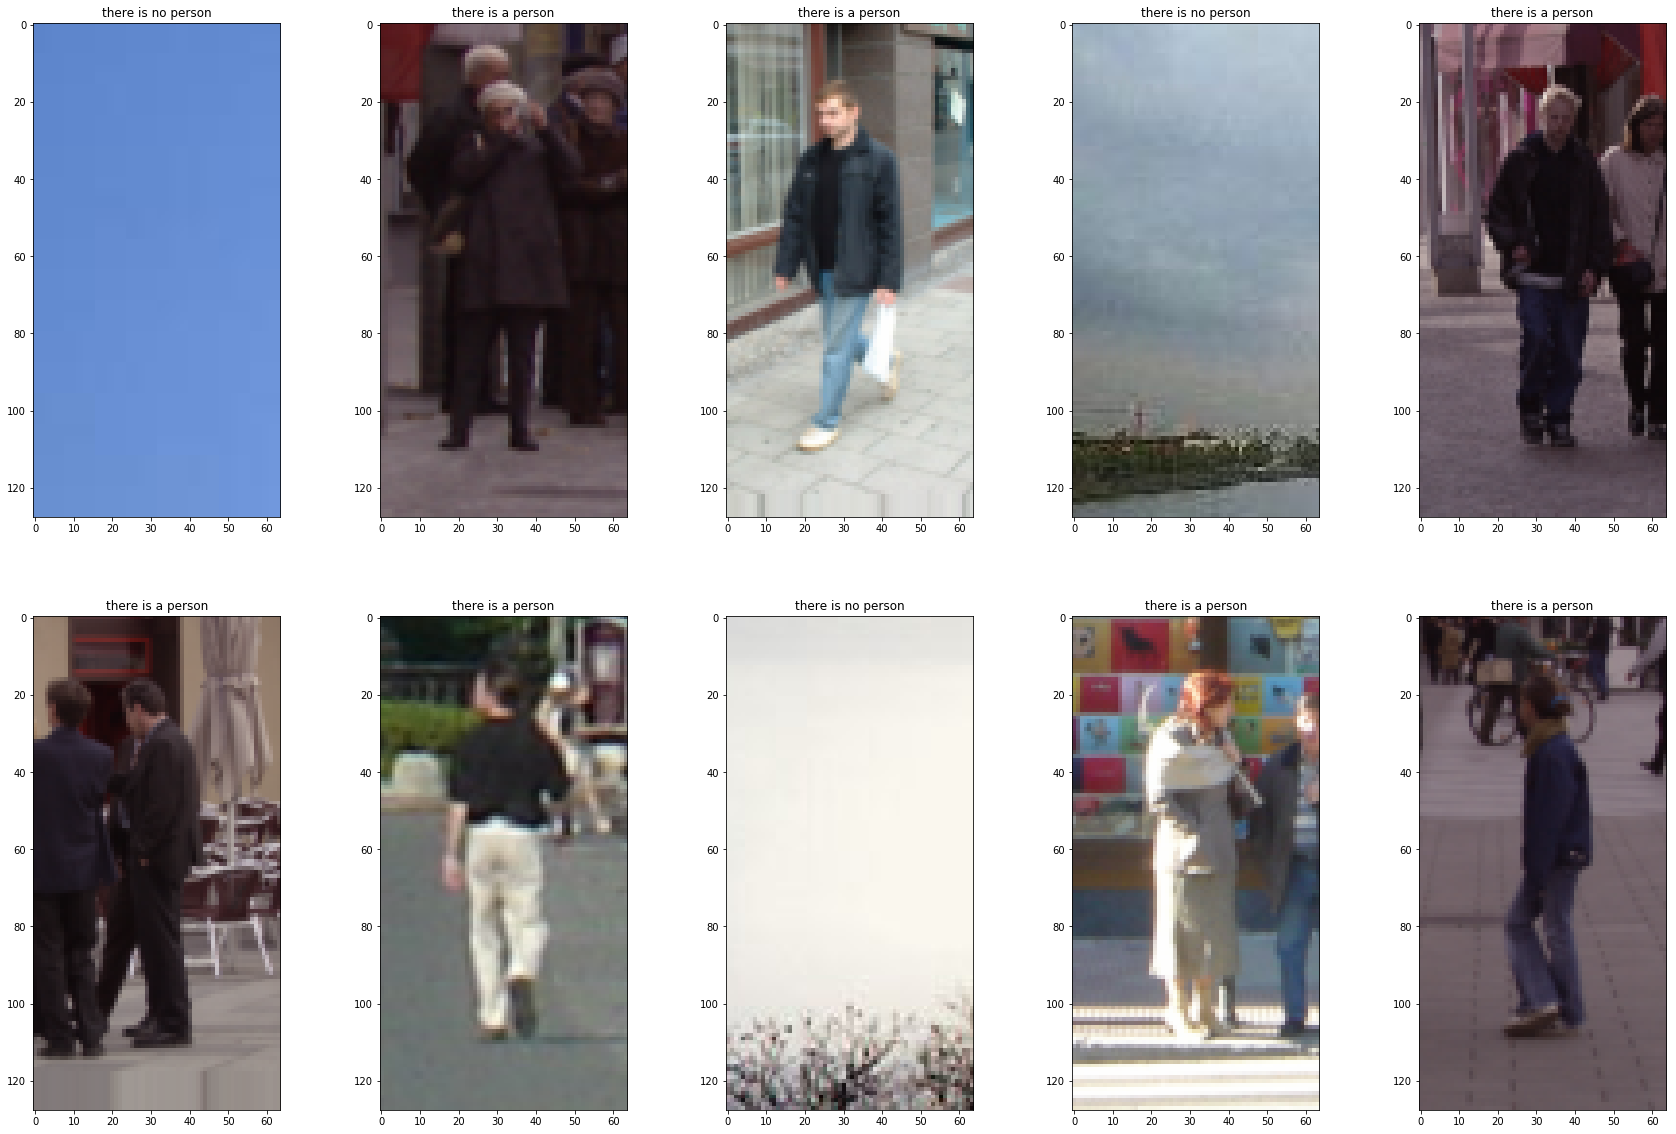

In [0]:
#test_datagen = ImageDataGenerator(rescale=1./255) 
test_datagen = ImageDataGenerator() 

#from keras.models import load_model
#loaded_model = load_model('model_keras_batch4_epochs16.h5')
#loaded_model.load_weights("model_wieghts_batch4_epochs16.h5")

i = 0
columns = 5
text_labels = []
plt.figure(figsize=(30,20))
for batch in test_datagen.flow(X_val, batch_size=1): # X_val instead of X_test
    pred = model.predict(batch)
    if pred > 0.5:
        text_labels.append('there is a person')
    else:
        text_labels.append('there is no person')
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.title(text_labels[i])
    imgplot = plt.imshow(batch[0])
    i += 1
    if i % 10 == 0:
        break
plt.show()

# Detection of pedestrian

In [0]:
# define the sliding window:
def sliding_window(image, stepSize, windowSize):# image is the input, step size is the no.of pixels needed to skip and windowSize is the size of the actual window
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):# this line and the line below actually defines the sliding part and loops over the x and y coordinates
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y: y + windowSize[1], x:x + windowSize[0]])

In [0]:
%matplotlib inline

from PIL import Image, ImageDraw
from skimage.transform import pyramid_gaussian
from imutils.object_detection import non_max_suppression

# upload the saved svm model:
#from keras.models import load_model
#loaded_model = load_model('/content/drive/My Drive/Colab Notebooks/Project31/model_keras_batch4_epochs16 (1).h5')
#loaded_model.load_weights("/content/drive/My Drive/Colab Notebooks/Project31/model_wieghts_batch4_epochs16 (1).h5")
#model = loaded_model

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


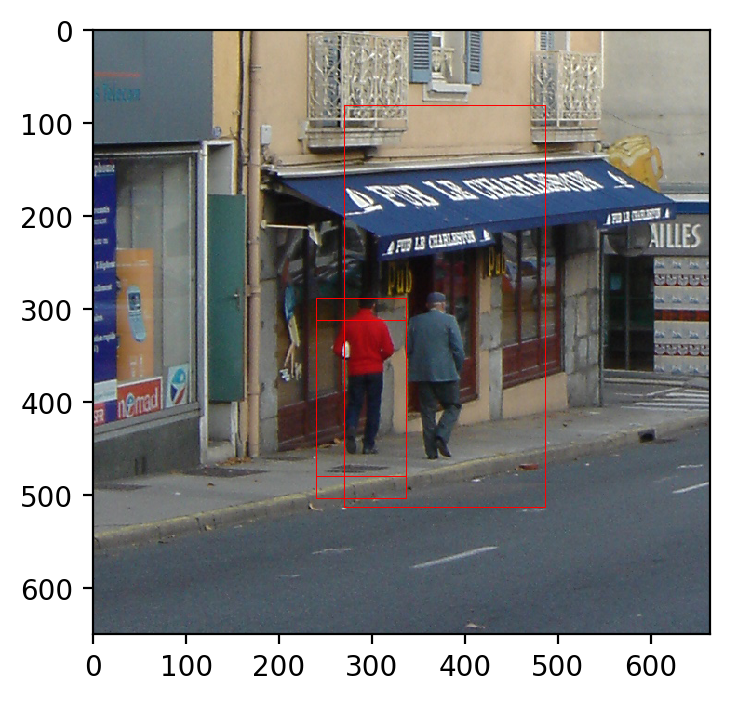

In [0]:
scale = 0
detections = []

# read the image you want to detect the object in:
image = Image.open('INRIAPerson/Test/pos/crop001504.png')

# resize image if it is too big
#image = image.resize((640,480)) 

# defining the size of the sliding window 
(winW, winH) = (64,128)
windowSize =(winW,winH)
downscale = 1.5

# Apply sliding window:
for resized in pyramid_gaussian(image, downscale=downscale): # loop over each layer of the image that you take!
    # loop over the sliding window for each layer of the pyramid
    for (x,y,window) in sliding_window(resized, stepSize=8, windowSize=(winW,winH)):
        # if the window does not meet our desired window size, ignore it!
        if window.shape[0] != winH or window.shape[1] !=winW: # ensure the sliding window has met the minimum size requirement
            continue
        fds = np.expand_dims(window, axis=0)
        pred = model.predict(fds) # use the SVM model to make a prediction on the HOG features extracted from the window
        
        if pred > 0.99:
            detections.append((int(x * (downscale**scale)), int(y * (downscale**scale)), 
                                   int(windowSize[0]*(downscale**scale)), # create a list of all the predictions found
                                      int(windowSize[1]*(downscale**scale))))
    scale+=1
    
    
draw = ImageDraw.Draw(image)    
clone = resized.copy()

#for (x_tl, y_tl, _, w, h) in detections:
  #  draw.rectangle([x_tl, y_tl, x_tl + w, y_tl + h], outline=(255, 0, 0))
rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in detections]) # do nms on the detected bounding boxes



pick = non_max_suppression(rects, overlapThresh = 0.3)

# Start drawing rectangles for each possible detection
for (xA, yA, xB, yB) in pick:
    draw.rectangle([xA, yA, xB, yB], outline=(255, 0, 0))

#image.show()
#imshow(np.asarray(image))

plt.figure(dpi=200)
plt.imshow(image)